# Interconnect Churn-Forcasting Initiative

This project explores customer churn within a telecommunications provider using multiple datasets that capture user behavior, contract details, personal data, and service usage (phone and internet). The objective is to identify patterns that contribute to churn and develop a predictive model to flag high-risk customers. By understanding these trends, the provider can take proactive steps to reduce attrition and improve customer retention strategies.


Heather Marie Culligan

May 2025

## Initialization

In [4]:
#importing needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

## Load Data

In [6]:
#load data sets
df_phone=pd.read_csv('/datasets/final_provider/phone.csv')
df_internet=pd.read_csv('/datasets/final_provider/internet.csv')
df_personal=pd.read_csv('/datasets/final_provider/personal.csv')
df_contract=pd.read_csv('/datasets/final_provider/contract.csv')

## EDA

### Pre-Process

In [7]:
#brief look at all our data sets before merge
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [8]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
#merge the four datasets into one on customerID
df_all=(
    df_personal
        .merge(df_contract, on='customerID', how='left')
        .merge(df_phone, on='customerID', how='left')
        .merge(df_internet, on='customerID', how='left')
)

In [12]:
#rename the columns to lowercase to help locate duplicates properly along with overall uniformity
df_all.rename(columns=str.lower, inplace=True)
for col in df_all.select_dtypes(include='object').columns:
    df_all[col]= df_all[col].str.lower()

In [13]:
#overview after merge and lowercase change
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   begindate         7043 non-null   object 
 6   enddate           7043 non-null   object 
 7   type              7043 non-null   object 
 8   paperlessbilling  7043 non-null   object 
 9   paymentmethod     7043 non-null   object 
 10  monthlycharges    7043 non-null   float64
 11  totalcharges      7043 non-null   object 
 12  multiplelines     6361 non-null   object 
 13  internetservice   5517 non-null   object 
 14  onlinesecurity    5517 non-null   object 
 15  onlinebackup      5517 non-null   object 
 16  deviceprotection  5517 non-null   object 


In [14]:
#view how the data is veiwed
df_all.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-vhveg,female,0,yes,no,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85,NaN,dsl,no,yes,no,no,no,no
1,5575-gnvde,male,0,no,no,2017-04-01,no,one year,no,mailed check,56.95,1889.5,no,dsl,yes,no,yes,no,no,no
2,3668-qpybk,male,0,no,no,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,no,dsl,yes,yes,no,no,no,no
3,7795-cfocw,male,0,no,no,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75,NaN,dsl,yes,no,yes,yes,no,no
4,9237-hqitu,female,0,no,no,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,no,fiber optic,no,no,no,no,no,no


In [15]:
#check the missing data, we will address in a few code blocks
missing= df_all.isnull().sum()
missing

customerid             0
gender                 0
seniorcitizen          0
partner                0
dependents             0
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
multiplelines        682
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
dtype: int64

In [16]:
#adjust the begindate to datetime
df_all['begindate']=pd.to_datetime(df_all['begindate'],format='%Y-%m-%d')

In [17]:
#process to change enddate and add churn column to the dataset
df_all['enddate'].isnull().sum(), df_all['enddate'].notna().sum()

(0, 7043)

In [18]:
df_all['enddate'] = df_all['enddate'].replace({'no': np.nan,'':np.nan})

In [19]:
df_all['enddate']=pd.to_datetime(df_all['enddate'],format='%Y-%m-%d',errors='coerce')

In [20]:
df_all['churn']=df_all['enddate'].notna().astype(int)

In [21]:
df_all['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

In [22]:
#change total charge column to numeric
df_all['totalcharges']=pd.to_numeric(df_all['totalcharges'],errors='coerce')

In [23]:
#adding tenure days column to dataset
today= pd.Timestamp.today().normalize()
df_all['tenure_days']=(today-df_all['begindate']).dt.days

In [24]:
#view to make sure all the changes above took place
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   seniorcitizen     7043 non-null   int64         
 3   partner           7043 non-null   object        
 4   dependents        7043 non-null   object        
 5   begindate         7043 non-null   datetime64[ns]
 6   enddate           1869 non-null   datetime64[ns]
 7   type              7043 non-null   object        
 8   paperlessbilling  7043 non-null   object        
 9   paymentmethod     7043 non-null   object        
 10  monthlycharges    7043 non-null   float64       
 11  totalcharges      7032 non-null   float64       
 12  multiplelines     6361 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity    5517 n

In [25]:
#take out all rows with nothing in begin date or total charges (not actual customers if these are empty and should not be in the dataset)
df_all.dropna(subset=['begindate','totalcharges'], inplace=True)

In [26]:
#any duplicates?
dup_counts= df_all.duplicated().sum()
dup_counts

0

In [27]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   seniorcitizen     7032 non-null   int64         
 3   partner           7032 non-null   object        
 4   dependents        7032 non-null   object        
 5   begindate         7032 non-null   datetime64[ns]
 6   enddate           1869 non-null   datetime64[ns]
 7   type              7032 non-null   object        
 8   paperlessbilling  7032 non-null   object        
 9   paymentmethod     7032 non-null   object        
 10  monthlycharges    7032 non-null   float64       
 11  totalcharges      7032 non-null   float64       
 12  multiplelines     6352 non-null   object        
 13  internetservice   5512 non-null   object        
 14  onlinesecurity    5512 n

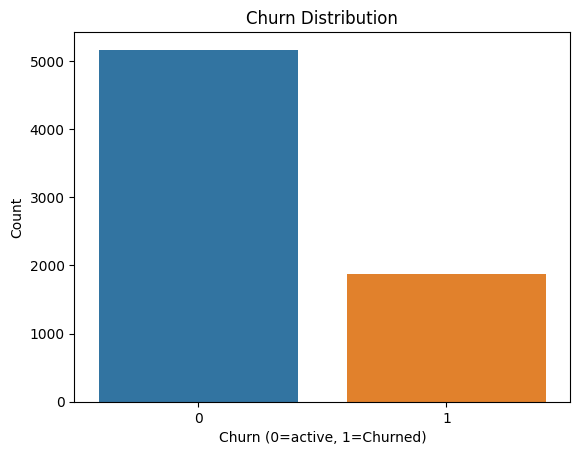

0    73.42
1    26.58
Name: churn, dtype: float64

In [28]:
#lets view our churn data
sns.countplot(data=df_all, x='churn')
plt.title('Churn Distribution')
plt.xlabel('Churn (0=active, 1=Churned)')
plt.ylabel('Count')
plt.show()

df_all['churn'].value_counts(normalize=True).mul(100).round(2)

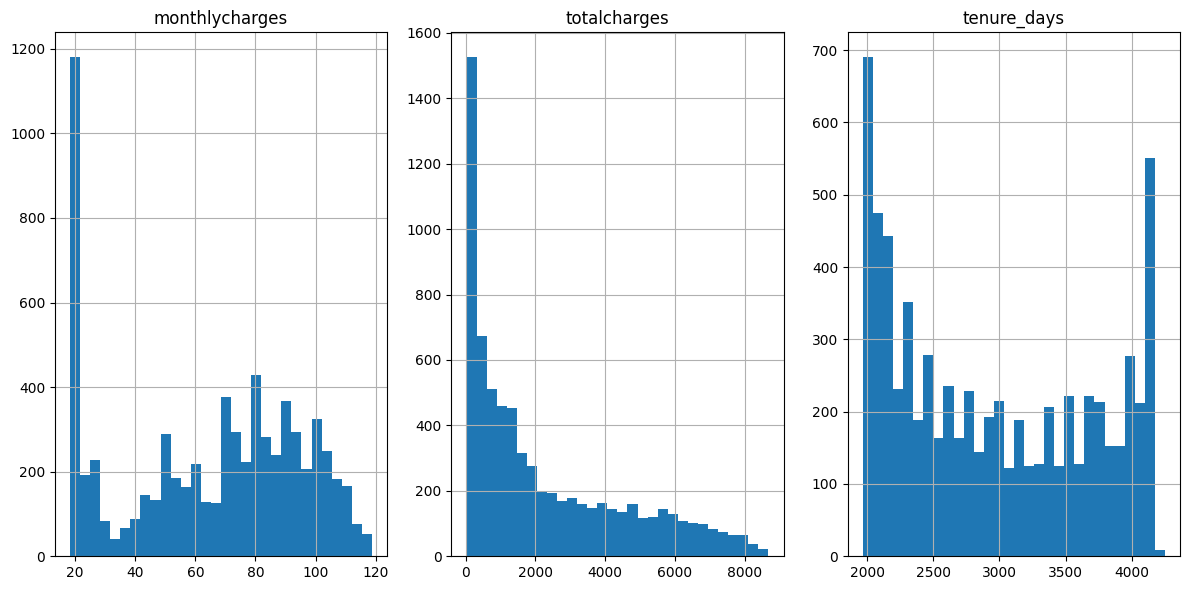

In [29]:
#view numerical features in the set
num_cols= ['monthlycharges','totalcharges','tenure_days']
df_all[num_cols].describe().T

df_all[num_cols].hist(bins=30, figsize=(12,6), layout=(1,3))
plt.tight_layout()
plt.show()

The numeric features show clear patterns. Monthly charges have two main groups, low and high,
likely based on service levels. Total charges are mostly low, with a few long-term users spending more. Tenure shows that many customers leave early, while others stay for years. These trends suggest that price and time with the company could help predict churn.

## Pre-Model Prep

In [30]:
#check missing data
df_all.isnull().sum()

customerid             0
gender                 0
seniorcitizen          0
partner                0
dependents             0
begindate              0
enddate             5163
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
multiplelines        680
internetservice     1520
onlinesecurity      1520
onlinebackup        1520
deviceprotection    1520
techsupport         1520
streamingtv         1520
streamingmovies     1520
churn                  0
tenure_days            0
dtype: int64

In [31]:
#filling rows with no instead of missing (these missings are likely due to the customers opting for other plans phone instead of internet, etc.)
service_cols = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
df_all[service_cols] = df_all[service_cols].fillna('no')

In [32]:
df_all['multiplelines'] = df_all['multiplelines'].fillna('no')

In [33]:
#re-checking missing values after filling
df_all.isnull().sum()

customerid             0
gender                 0
seniorcitizen          0
partner                0
dependents             0
begindate              0
enddate             5163
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
multiplelines          0
internetservice        0
onlinesecurity         0
onlinebackup           0
deviceprotection       0
techsupport            0
streamingtv            0
streamingmovies        0
churn                  0
tenure_days            0
dtype: int64

In [34]:
#scale data
num_cols = ['monthlycharges', 'totalcharges', 'tenure_days']

scaler = StandardScaler()

df_all[num_cols]= scaler.fit_transform(df_all[num_cols])

df_all[num_cols].describe().round(2)

,monthlycharges,totalcharges,tenure_days
count,7032.00,7032.00,7032.00
mean,0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-1.55,-1.00,-1.33
25%,-0.97,-0.83,-0.95
50%,0.18,-0.39,-0.17
75%,0.83,0.67,0.95
max,1.79,2.82,1.77


In [35]:
#one-hot encode
cat_cols = ['type','paymentmethod', 'internetservice']

df_all = pd.get_dummies(df_all, columns= cat_cols, drop_first= True)
 
df_all.filter(like='type_').head(1)

,type_one year,type_two year
0,0,0


## Feature Engineering

In [36]:
#remove non booleen from service_cols and then run counts on subscribed services (doing it this way for a permanent change to the column from this block forward instead of using .remove())
service_cols = ['onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']

df_all[service_cols] = df_all[service_cols].replace({'yes':1, 'no': 0})

df_all['num_services']=df_all[service_cols].sum(axis=1)

df_all['num_services'].head(5)

0    1
1    2
2    2
3    3
4    0
Name: num_services, dtype: int64

In [37]:
#binary flag for paperless billing, gender, partner, dependants
binary_cols = ['gender', 'partner', 'dependents', 'paperlessbilling', 'multiplelines']
df_all[binary_cols] = df_all[binary_cols].replace({'yes': 1, 'no': 0, 'female': 0, 'male': 1})

## Model Development

In [38]:
#features and target
X= df_all.drop(columns=['enddate','begindate','customerid','churn'])
y=df_all['churn']

#split test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X,y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

#split remaining to train and validation sets(15% of remaining[0.15/0.85=0.1764705882])
X_train,X_val, y_train, y_val= train_test_split(
    X_temp, y_temp,
    test_size=0.1765,
    stratify=y_temp,
    random_state=42
)

#check distribution through
print("Churn distribution:")
print("Train:", y_train.mean().round(3))
print("Validation:", y_val.mean().round(3))
print("Test:", y_test.mean().round(3))

Churn distribution:
Train: 0.266
Validation: 0.265
Test: 0.265


In [39]:
#baseline model using Logistic Regression
baseline_model= LogisticRegression(random_state=42, max_iter=1000)

baseline_model.fit(X_train, y_train)

y_val_proba = baseline_model.predict_proba(X_val)[:,1]

#AUC-ROC
val_auc= roc_auc_score(y_val, y_val_proba)
print(f"Validation AUC-ROC: {val_auc: .3f}")

Validation AUC-ROC:  0.829


In [40]:
#lightGBM
lgb_model= lgb.LGBMClassifier(random_state=42)

lgb_model.fit(X_train, y_train)

y_val_proba = lgb_model.predict_proba(X_val)[:,1]

val_auc_lgb= roc_auc_score(y_val, y_val_proba)
print(f"Validation AUC-ROC (LightGBM): {val_auc_lgb:.3f}")

Validation AUC-ROC (LightGBM): 0.919


In [41]:
#optional tuning
param_dist = {
    'num_leaves': randint(20,100),
    'max_depth': randint(3,15),
    'learning_rate': uniform(0.01,0.2),
    'n_estimators': randint(100,500),
    'min_child_samples': randint(10,50),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6,0.4)
}

lgb_clf = lgb.LGBMClassifier(random_state=42)

random_search  = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_model= random_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [42]:
val_auc= roc_auc_score(y_val, y_val_proba)
print(f"Validation AUC-ROC (Tuned): {val_auc: .3f}")

Validation AUC-ROC (Tuned):  0.919


In [43]:
#test set
y_test_proba= best_model.predict_proba(X_test)[:,1]

#Test set AUC-ROC
test_auc= roc_auc_score(y_test, y_test_proba)
print(f"Test AUC-ROC (Tuned LightGBM): {test_auc: .3f}")

Test AUC-ROC (Tuned LightGBM):  0.931


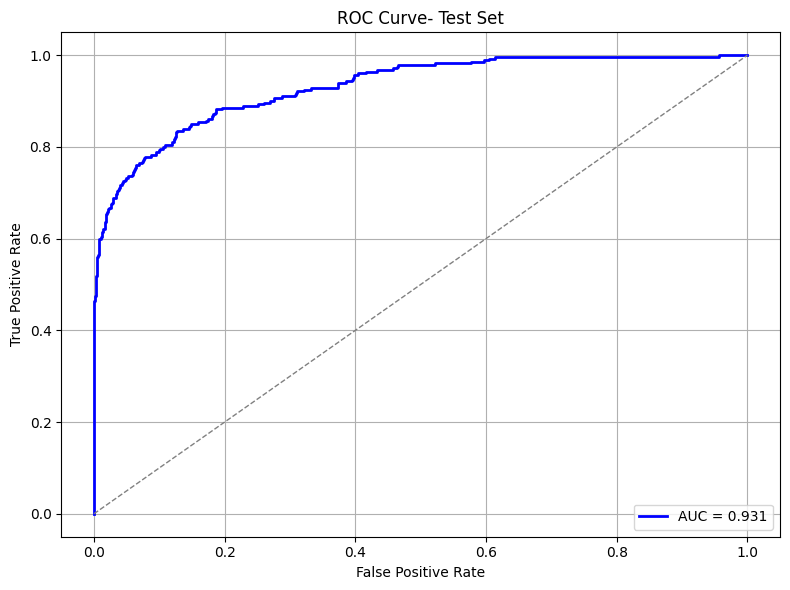

In [50]:
fpr,tpr, thresholds= roc_curve(y_test, y_test_proba)
roc_auc= auc(fpr,tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Analysis/ Evaluation

The final model is a tuned LightGBM classifier, chosen for its strong performance in predicting customer churn. It achieved a test AUC-ROC of 0.931, exceeding the project goal of 0.88. The model was trained on a clean, well-prepared dataset, and hyperparameters were optimized using randomized search. Its high accuracy and consistent results across validation and test sets make it a reliable tool for identifying high-risk customers.

## Conclusion

This project successfully developed a churn prediction model using customer data from a telecom provider. After preparing and analyzing the data, a tuned LightGBM classifier was trained and selected as the final model. It achieved a test AUC-ROC of 0.931, exceeding the project’s performance goal. The results show that customer tenure, contract type, and service usage are strong indicators of churn risk. The final model is well-suited to support proactive retention efforts in a real-world setting.

## Report

This project built a churn-prediction model for a telecom provider. I merged the four source tables, cleaned missing values, and removed duplicates. After an initial EDA, I engineered key features such as tenure_days, service counts, and binary flags for contract and billing types. All planned steps were completed; I skipped only extra visualizations that didn’t add new insight.

The main challenges were data leakage and text-based binary fields. At first, tenure_days used enddate, which revealed churn. I fixed this by basing tenure solely on begindate and today’s date. I also converted 'yes'/'no' and 'male'/'female' to numeric flags and filled service-related nulls with “no,” since they indicated non-subscription.

Clean data and solid features made the difference. A baseline logistic regression set the bar, but a tuned LightGBM model performed best. After randomized hyperparameter search, the final model reached an AUC-ROC of 0.931 on the test set, beating the 0.88 target and showing strong generalization. This model can now flag high-risk customers for proactive retention efforts.